In [2]:
import sys
sys.path.insert(0, '/nfs/mwa-09/r1/abrahamn/21cmIR/21cmIRxcor')
import mwa_utils

In [11]:
import pickle
import numpy as np
from numpy import pi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
# MWA uv space sampling
analysis_root = '/nfs/mwa-09/r1/abrahamn/21cmIR/analysis/'
fhddeeplabel = 'Combined_obs_wedge_cut_plus_res_cut'
mwa_deep_image = pickle.load( open( analysis_root+fhddeeplabel+'.p', "rb" ) )

<matplotlib.colorbar.Colorbar instance at 0x4e5b710>

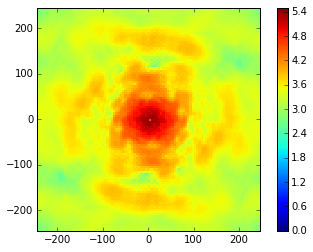

In [13]:
# the total obs time in each uv cell is proportional to weights_uv
weights_uv = np.abs(np.fft.fft2(mwa_deep_image.weights_xx0))

t_obs_21_sec = 3*3600.

Nant = 112 # 128 MWA ants minus 16 outriggers
num_baselines = Nant*(Nant-1)/2
num_seconds_per_uv = weights_uv/np.sum(weights_uv)*np.sum(num_baselines*t_obs_21_sec)

lamda = 300./185
du = 1./(mwa_deep_image.n*mwa_deep_image.dtheta_rad)
umax = du*mwa_deep_image.n/2

plt.imshow(np.log10(np.fft.fftshift(num_seconds_per_uv)),interpolation='nearest',vmin=0,vmax=5.5,extent=[-umax,umax,-umax,umax])
plt.colorbar()

In [14]:
# cosmology
from cosmocalc import cosmocalc
WM,WV = 0.27,0.73
c = 3.e8
h = 6.626e-34 # J*sec
c_over_H0_Mpc = 4283.

In [15]:
# experimental params
z = 7.
Deltaz = 1.5

Ez = np.sqrt(WM*(1+z)**3+WV)

D = cosmocalc(z,WM=WM,WV=WV)['DCMR_Mpc']
DeltaD = c_over_H0_Mpc*Deltaz/Ez
wedgeslope = D*Ez/(c_over_H0_Mpc*(1+z))*(pi/2)

In [16]:
# perp sampling
theta_fov_rad = mwa_deep_image.n*mwa_deep_image.dtheta_rad
dtheta_rad = mwa_deep_image.dtheta_rad
Nperp = mwa_deep_image.n

In [17]:
# IR expt
lamda0_IR_m = 120.e-9

R_IR = 80.
dz = (1+z)/R_IR
Nf = int(Deltaz / dz)

B_IR = Deltaz*c/lamda0_IR_m/(1+z)**2

In [18]:
# 21cm expt
f0_21_Hz = 1420.e6
B_Hz = Deltaz*f0_21_Hz/(1+z)**2

In [19]:
dkpara = 2.*pi/DeltaD
kparamax = Nf/2*dkpara

dkperp = 2.*pi/(theta_fov_rad*D)
kperpmax = Nperp/2*dkperp

kparavals = np.fft.fftfreq(Nf)*Nf*dkpara
kperpvals = np.fft.fftfreq(Nperp)*Nperp*dkperp
kzgrid,kxgrid,kygrid = np.meshgrid(kparavals,kperpvals,kperpvals,indexing='ij')

kmaggrid = np.sqrt(kxgrid**2+kygrid**2+kzgrid**2)
kmax = np.max(kmaggrid)

(array([   525.,   3668.,   9952.,  18014.,  23516.,  28640.,  33090.,
         21356.,   9348.,   1891.]),
 array([ 0.        ,  0.02603011,  0.05206021,  0.07809032,  0.10412043,
         0.13015054,  0.15618064,  0.18221075,  0.20824086,  0.23427096,
         0.26030107]),
 <a list of 10 Patch objects>)

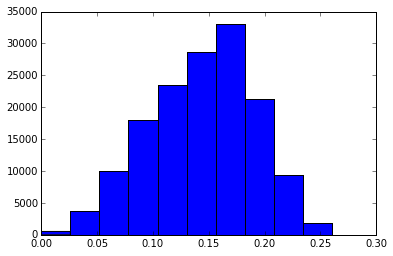

In [20]:
plt.hist(kmaggrid.flatten())

In [21]:
# 21cm thermal noise
# https://www.evernote.com/shard/s316/nl/2147483647/6f7c9ac4-f872-407d-89e3-acb8fdff1982/
    
Tsky_K = 150.
A = 20. # m^2
B_Hz = 30.e6 # MHz
P_21_thermal = Tsky_K*lamda**2*D**2*DeltaD/(B_Hz*A*num_seconds_per_uv)

P_21_thermal_veck = np.repeat([P_21_thermal],Nf,axis=0)

In [22]:
# IR shot noise
# https://www.evernote.com/shard/s316/nl/2147483647/89eb8fb1-82bf-46c2-a07a-4c81d1fd171b/

# https://www.evernote.com/shard/s316/nl/2147483647/0b490f35-5419-452a-9350-371cc062850b/
kjy = 1000 * 1.e-26
Isky = 1.6 # kJy/sr 
hf = h*c/(lamda0_IR_m*(1+z))
t_obs_ir_sec = 15.
A = .5**2 # m^2
P_IR_shot = D**2*DeltaD*hf*Isky/(B_IR*t_obs_ir_sec*A*kjy)

P_IR_shot_veck = np.tile(P_IR_shot,(Nf,Nperp,Nperp))

In [23]:
nbins = 5
kbinedges = np.linspace(0,kmax,nbins+1)
kbincenters = .5*(kbinedges[0:nbins]+kbinedges[1:nbins+1])

P_binned = np.zeros(nbins)
bin_counts = np.zeros(nbins)
#bin_weights = np.zeros(nbins)
for bini in range(nbins):
    inbin = np.logical_and(kmaggrid>kbinedges[bini],kmaggrid<kbinedges[bini+1])
    bin_counts[bini] = np.sum(inbin)

    P_binned[bini] = np.sqrt(1./(np.sum( 1./(P_IR_shot_veck[inbin]*P_21_thermal_veck[inbin]) )))
    #bin_weights[bini] = np.sum(weight_ft[inbin]**2)

In [33]:
# load Silva's theoretical xspec
dattheory = np.genfromtxt('silva_theoretical_xspec.csv',skip_header=1,delimiter=',')
ktheory = dattheory[:,0]
Deltatheory = dattheory[:,1] # units of [erg/sec/cm^2/sr]^2

f_ir_obs = c/(lamda0_IR_m*(1+z))
convert_ir_units = 1.e-7/(1.e-2)**2/kjy/f_ir_obs

Kb = 1.38e-23
lamda_21_obs = c*(1+z)/f0_21_Hz
f_21_obs = f0_21_Hz/(1+z)
convert_21_units = 1.e-7/(1.e-2)**2*lamda_21_obs**2/Kb/f_21_obs

Ptheory = 2*pi**2/ktheory**3*Deltatheory*convert_ir_units*convert_21_units

In [41]:
Ptheory

array([  8.00347338e+19,   7.87960397e+19,   3.03017119e+19,
         8.22061158e+18,   2.67832518e+18,   1.13065910e+18,
         5.67259339e+17,   2.10213207e+17,   9.08819672e+16,
         2.89126270e+16,   9.61406544e+15,   3.64867146e+15,
         1.58557202e+15,   7.94399040e+14,   3.94677700e+14,
         1.96726032e+14,   7.27895960e+13])

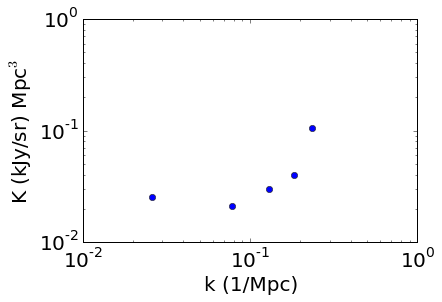

In [33]:
matplotlib.rcParams.update({'font.size': 20})

plt.loglog(kbincenters,P_binned,'o')
plt.xlabel('k (1/Mpc)')
plt.ylabel(r'K (kJy/sr) Mpc$^3$')